# Runbook for converting [Maxim models](https://github.com/google-research/maxim) into Tensorflow.js-compatible models.

Start by installing dependencies, and cloning the relevant repository ([we use the Tensorflow port](https://github.com/sayakpaul/maxim-tf)):

In [ ]:
!pip install tensorflowjs scikit-image numpy tensorflow tensorflow_hub flax jax matplotlib Pillow
!npm install

In [2]:
# Copy the forked version, avoid any future conflicts
!git clone https://github.com/thekevinscott/maxim-tf.git maxim_tf

fatal: destination path 'maxim_tf' already exists and is not an empty directory.


In [3]:
%load_ext autoreload
%autoreload 2
import pathlib
import os
from utils import download_python_model, convert_to_tfjs, evaluate_models

## Model Definitions & Constants

[Here are all the MAXIM trained model checkpoints](https://github.com/google-research/maxim#results-and-pre-trained-models). We choose the models with the best performance (aside from Dehazing, for which we choose both indoor and outdoor, and Enhancement, for which we use both datasets).

We also have model-specific images we'll use to run inference against.

In [4]:
models_and_images = [
    # (Task, Dataset, Sample Image)
    ('Dehazing', 'SOTS-Indoor', 'https://github.com/google-research/maxim/raw/main/maxim/images/Dehazing/input/0003_0.8_0.2.png'),
    ('Dehazing', 'SOTS-Outdoor', 'https://github.com/google-research/maxim/raw/main/maxim/images/Dehazing/input/1444_10.png'),
    ('Denoising', 'SIDD', 'https://github.com/google-research/maxim/raw/main/maxim/images/Denoising/input/0003_30.png'),
    ('Deblurring', 'GoPro', 'https://github.com/google-research/maxim/raw/main/maxim/images/Deblurring/input/1fromGOPR0950.png'),
    ('Deraining', 'Rain13k', 'https://github.com/google-research/maxim/raw/main/maxim/images/Deraining/input/15.png'),
    ('Enhancement', 'LOL', 'https://github.com/google-research/maxim/raw/main/maxim/images/Enhancement/input/a4541-DSC_0040-2.png'),
    ('Enhancement', 'FiveK', 'https://github.com/google-research/maxim/raw/main/maxim/images/Enhancement/input/a4541-DSC_0040-2.png'),
]

And choose output folders:

In [5]:
PYTHON_MODEL_OUTPUT_FOLDER = pathlib.Path('./models/python')
TFJS_MODEL_OUTPUT_FOLDER = pathlib.Path('./models/tfjs')
IMAGES_OUTPUT_FOLDER = pathlib.Path('./images')
SHOULD_EVALUATE_MODELS = True # Whether we should evaluate the models after creating them
QUANTIZATION_SETTINGS = '--quantize_float16=*' # Set to '' for an uncompressed version. Can also choose --quantize_uint16=* or --quantize_uint8=*
FORCE_CREATE = False # If set to true, will re-create saved models

## Create the Models

Creating a python model for task "Dehazing" and dataset "SOTS-Indoor"
Creating a Tensorflow.js model for task "Dehazing" and dataset "SOTS-Indoor"
Evaluating Python and Tensorflow.js models for task "Dehazing" and dataset "SOTS-Indoor"

Python output


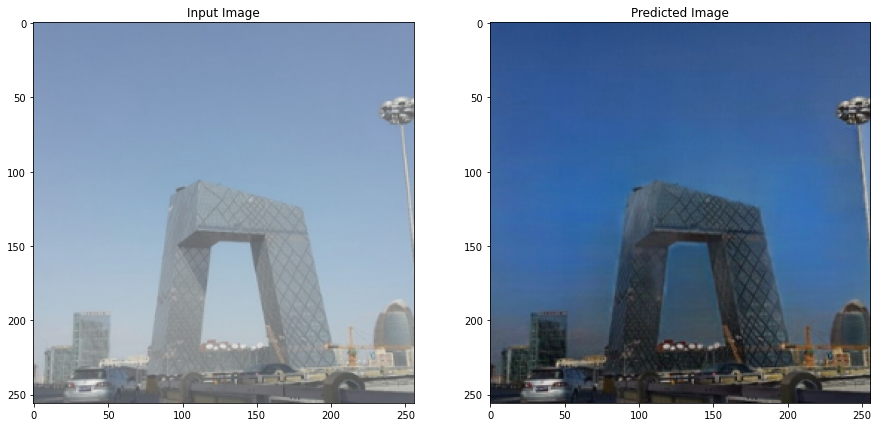

Node output


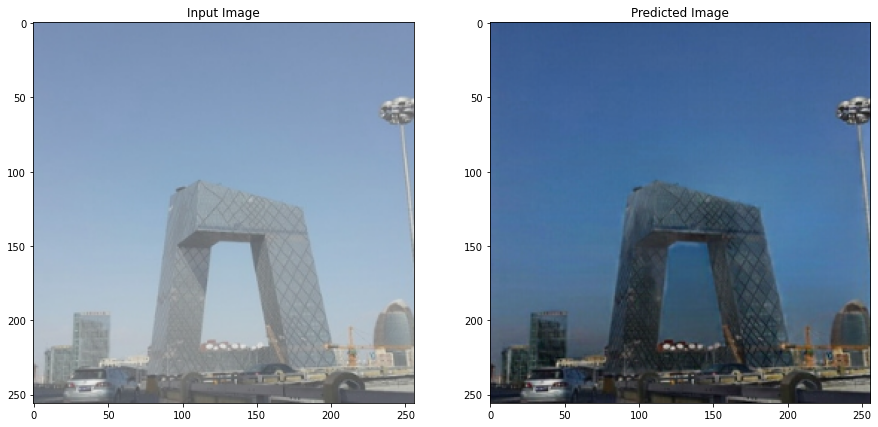

Creating a python model for task "Dehazing" and dataset "SOTS-Outdoor"
Creating a Tensorflow.js model for task "Dehazing" and dataset "SOTS-Outdoor"
Evaluating Python and Tensorflow.js models for task "Dehazing" and dataset "SOTS-Outdoor"

Python output


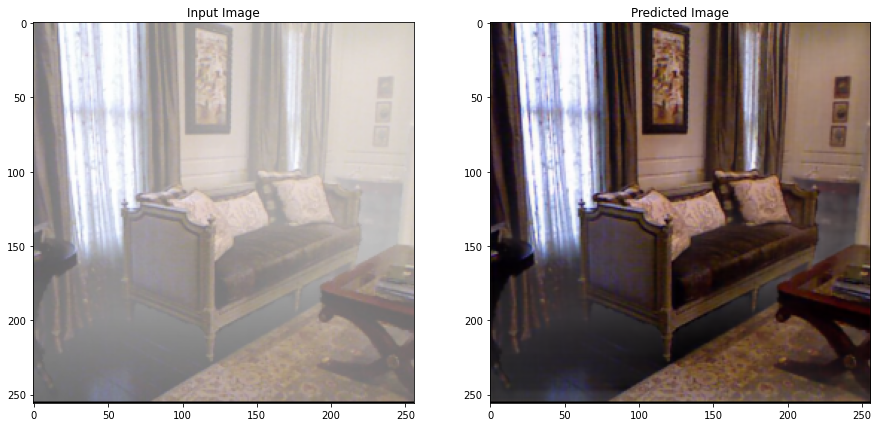

Node output


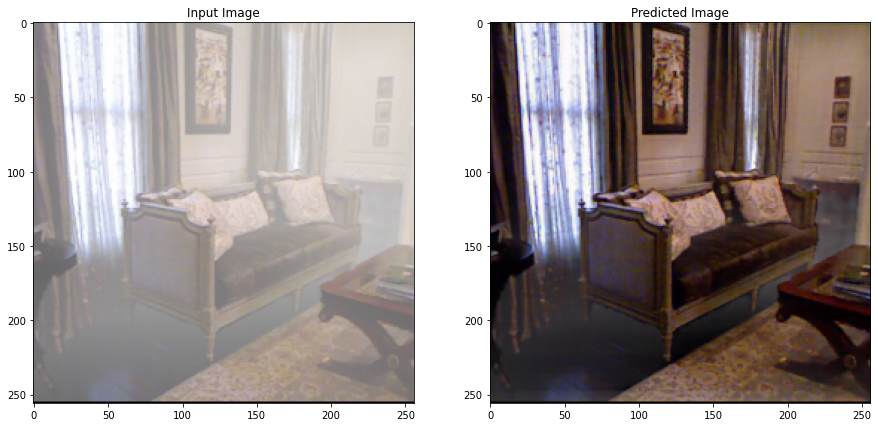

Creating a python model for task "Denoising" and dataset "SIDD"
Creating a Tensorflow.js model for task "Denoising" and dataset "SIDD"
Evaluating Python and Tensorflow.js models for task "Denoising" and dataset "SIDD"

Python output


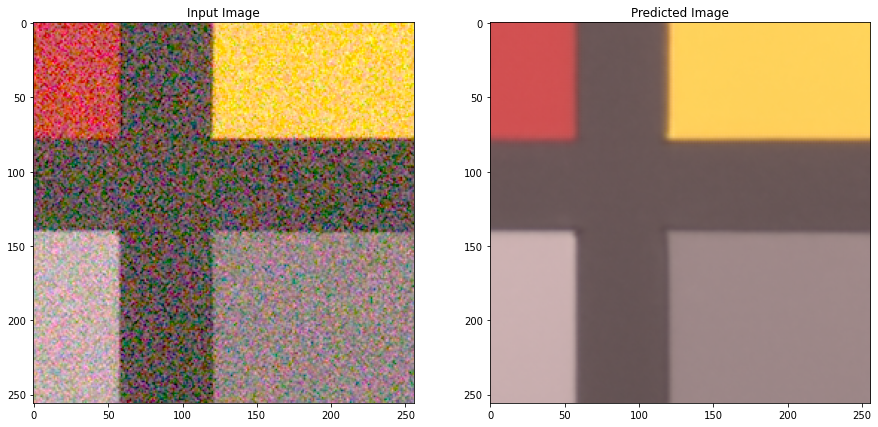

Node output


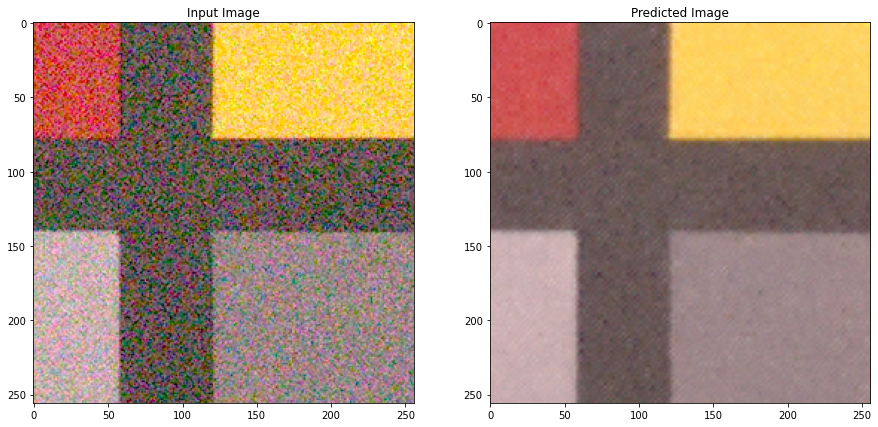

Creating a python model for task "Deblurring" and dataset "GoPro"
Creating a Tensorflow.js model for task "Deblurring" and dataset "GoPro"
Evaluating Python and Tensorflow.js models for task "Deblurring" and dataset "GoPro"

Python output


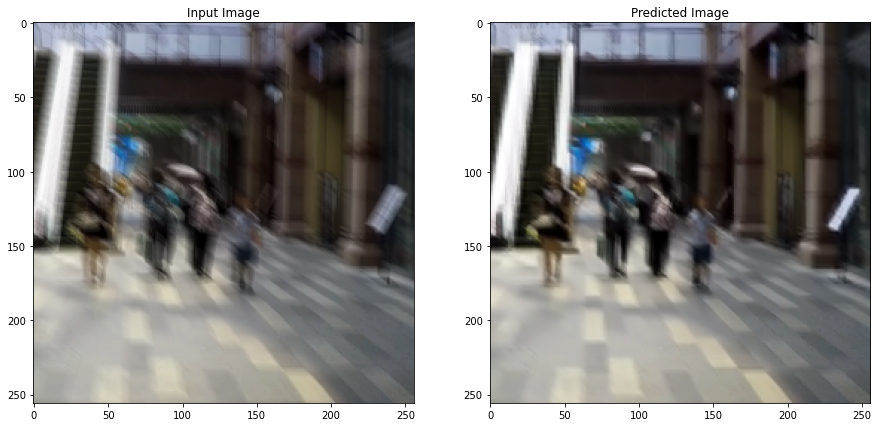

Node output


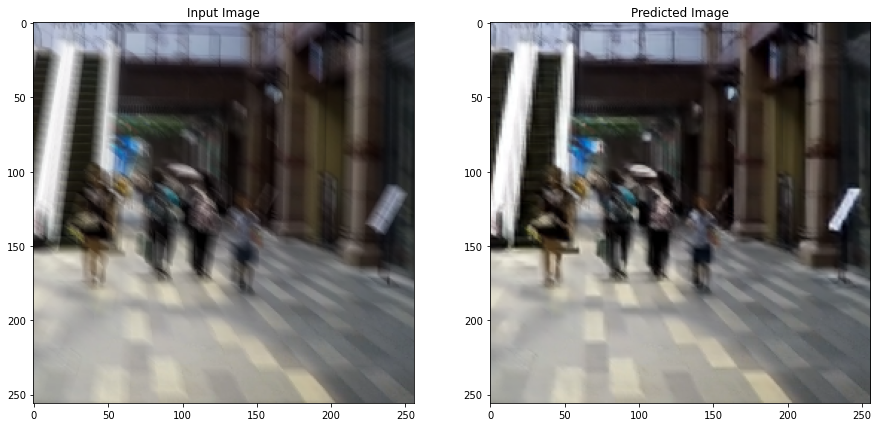

Creating a python model for task "Deraining" and dataset "Rain13k"
Creating a Tensorflow.js model for task "Deraining" and dataset "Rain13k"
Evaluating Python and Tensorflow.js models for task "Deraining" and dataset "Rain13k"

Python output


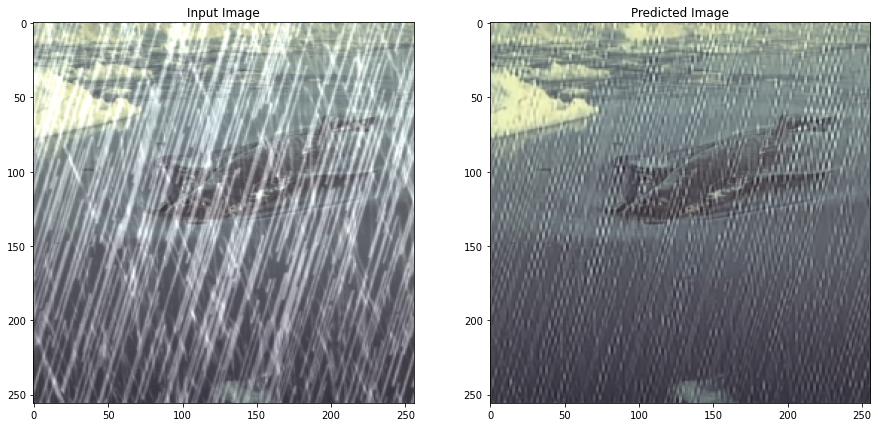

Node output


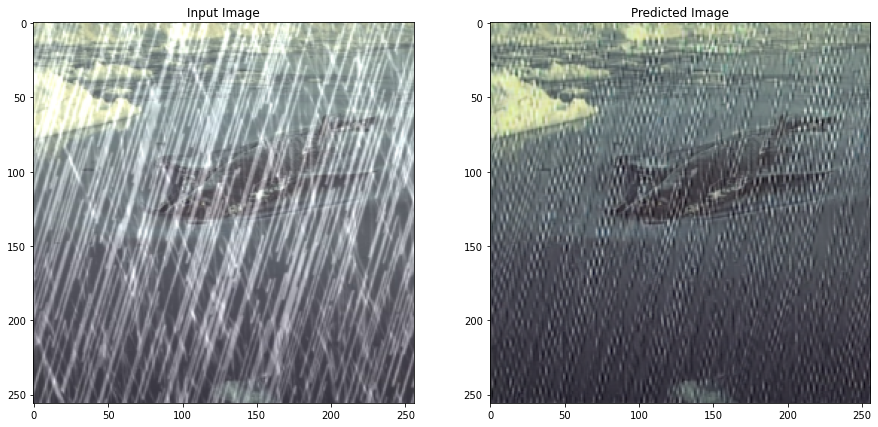

Creating a python model for task "Enhancement" and dataset "LOL"
Creating a Tensorflow.js model for task "Enhancement" and dataset "LOL"
Evaluating Python and Tensorflow.js models for task "Enhancement" and dataset "LOL"

Python output


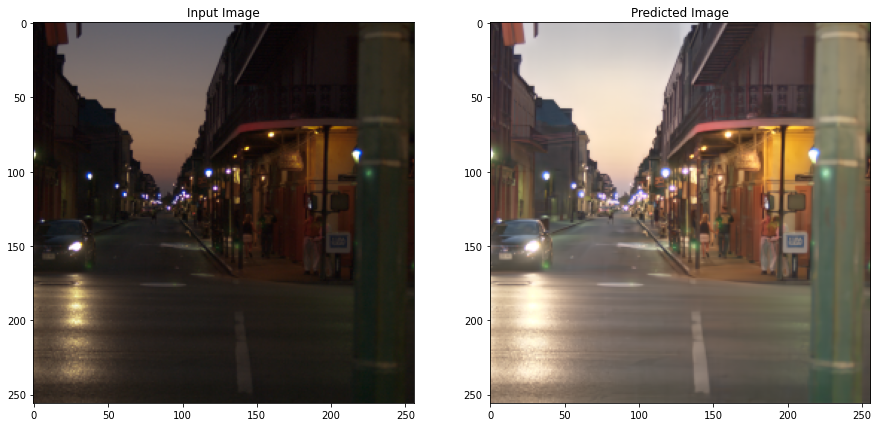

Node output


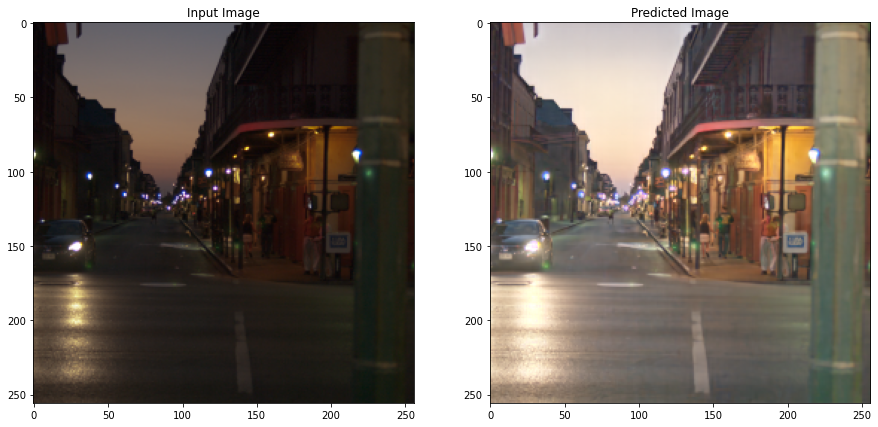

Creating a python model for task "Enhancement" and dataset "FiveK"
Creating a Tensorflow.js model for task "Enhancement" and dataset "FiveK"
Evaluating Python and Tensorflow.js models for task "Enhancement" and dataset "FiveK"

Python output


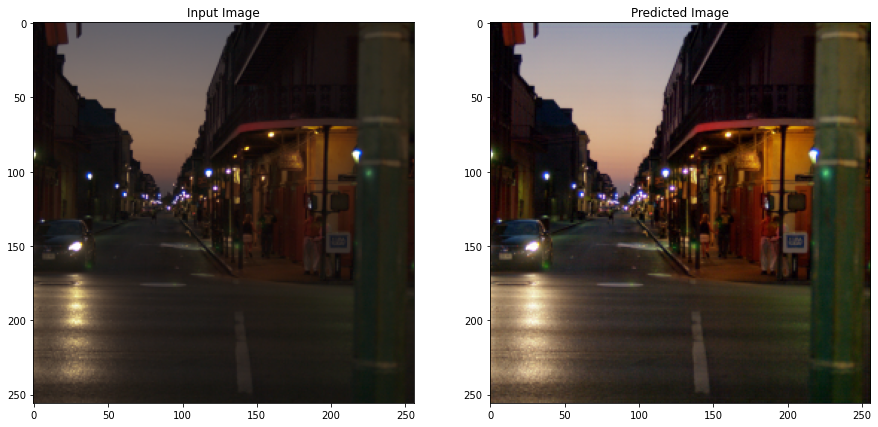

Node output


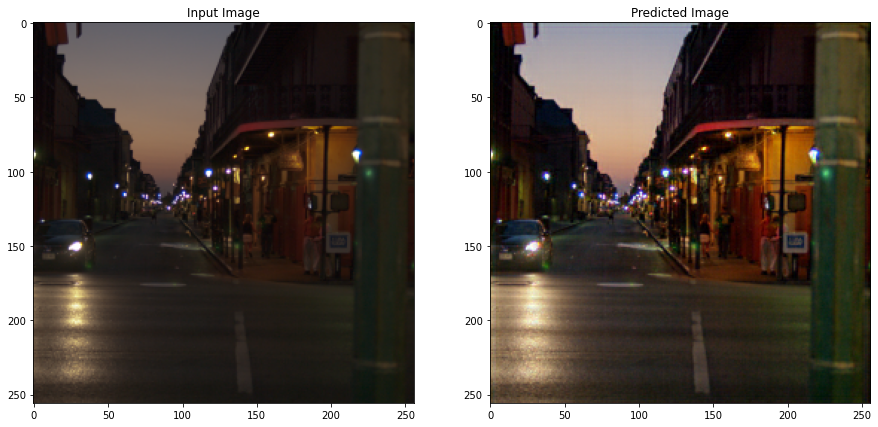

In [6]:
for task, dataset, sample_image in models_and_images:
    checkpoint_path = f'gs://gresearch/maxim/ckpt/{task}/{dataset}/checkpoint.npz' # path to the checkpoint on google storage
    
    # Download a MAXIM model and save it locally, if we have not already done so
    task_python_model_output_folder = PYTHON_MODEL_OUTPUT_FOLDER / task / dataset
    if os.path.exists(task_python_model_output_folder) is False or FORCE_CREATE:
        print(f'Creating a python model for task "{task}" and dataset "{dataset}"')
        download_python_model(task, checkpoint_path, task_python_model_output_folder)
        
    # Convert the Python model into a TFJS model, if we have not already done so
    task_tfjs_model_output_folder = TFJS_MODEL_OUTPUT_FOLDER / task / dataset
    if os.path.exists(task_tfjs_model_output_folder) is False or FORCE_CREATE:
        print(f'Creating a Tensorflow.js model for task "{task}" and dataset "{dataset}"')
        convert_to_tfjs(task_python_model_output_folder, task_tfjs_model_output_folder, QUANTIZATION_SETTINGS)
        
    if SHOULD_EVALUATE_MODELS:
        print(f'Evaluating Python and Tensorflow.js models for task "{task}" and dataset "{dataset}"')
        image_path = IMAGES_OUTPUT_FOLDER / task / dataset
        image_path.mkdir(exist_ok=True, parents=True)
        evaluate_models(task_python_model_output_folder, task_tfjs_model_output_folder, image_path / 'image.png', sample_image)